In [1]:
from olfactometer_ingestion import create_device, populate_software_events
from harp.io import read
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.integrate import simpson
import statistics as stats
from scipy.signal import find_peaks
import random
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

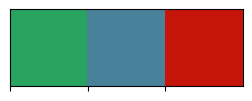

In [2]:
color = ['#28A460','#47829A','#C41508']
t_palette = sns.color_palette(color)
sns.palplot(t_palette)

In [3]:
sns.set_palette(t_palette)

In [4]:
TARGET_PATH = Path(r"C:\Users\huy.nguyen\Downloads\20240301T160321 1\20240301T160321")
OLFACTOMETER = create_device("Olfactometer")
ANALOG_INPUT = create_device("AnalogInput")
SOFTWARE_EVENTS = populate_software_events(root_path=TARGET_PATH)

In [5]:
ChannelsTargetFlow = read(TARGET_PATH/"Olfactometer.harp/Register__ChannelsTargetFlow.bin")
EnableFlow = read(TARGET_PATH/"Olfactometer.harp/Register__EnableFlow.bin")
EndValveState = read(TARGET_PATH/"Olfactometer.harp/Register__EndValveState.bin")
OdorValveState = read(TARGET_PATH/"Olfactometer.harp/Register__OdorValveState.bin")
ValveClear = read(TARGET_PATH/"Olfactometer.harp/Register__ValveClear.bin")
ValveSet = read(TARGET_PATH/"Olfactometer.harp/Register__ValveSet.bin")
ValveToggle = read(TARGET_PATH/"Olfactometer.harp/Register__ValveTogGle.bin")

In [6]:
mixture = OLFACTOMETER.ChannelsTargetFlow.read(TARGET_PATH/"Olfactometer.harp/Register__ChannelsTargetFlow.bin")
mixture

,Channel0,Channel1,Channel2,Channel3,Channel4
Time,,,,,
681743.395520,0.0,0.0,100.0,500.0,400.0
681743.411488,0.0,0.0,100.0,500.0,400.0
681868.536544,0.0,100.0,0.0,500.0,400.0
681993.661536,100.0,0.0,0.0,500.0,400.0
682118.775520,0.0,0.0,0.0,500.0,500.0
...,...,...,...,...,...
682468.183520,100.0,0.0,0.0,500.0,400.0
682470.186528,0.0,0.0,0.0,500.0,500.0
682480.190528,100.0,0.0,0.0,500.0,400.0


In [7]:
endValve = OLFACTOMETER.EndValveState.read(TARGET_PATH/"Olfactometer.harp/Register__EndValveState.bin")
endValve.head(10)

,EndValve0,EndValve1,ValveDummy
Time,,,
681743.391488,False,False,False
681743.461504,False,False,False
681758.408480,True,False,False
681760.412480,False,False,False
681770.422496,True,False,False
681772.423488,False,False,False
681782.435488,True,False,False
681784.446496,False,False,False
681794.456480,True,False,False


In [8]:
analog = ANALOG_INPUT.AnalogData.read(TARGET_PATH/"AnalogInput.harp/Register__33.bin")["Channel0"]
analog.head(10)

Time
681742.376992    1673
681742.377984    1674
681742.378976    1676
681742.380000    1676
681742.380992    1670
681742.381984    1672
681742.382976    1670
681742.384000    1669
681742.384992    1672
681742.385984    1672
Name: Channel0, dtype: int16

In [9]:
SOFTWARE_EVENTS.keys()

dict_keys(['IsEndValveCalibration', 'OdorChannel', 'OdorConfig'])

In [10]:
odor_config = SOFTWARE_EVENTS["OdorConfig"]["data"]
odor_config = pd.DataFrame(odor_config.values.tolist(), index = odor_config.index)
odor_config = odor_config.iloc[:, 0:2]
odor_config

,channel_index,odorant
Seconds,,
681743.392000,2,AmylAcetate
681868.532992,1,AlphaPinene
681993.658976,0,Eugenol
682118.772992,2,AmylAcetate
682243.917984,1,AlphaPinene
682369.069984,0,Eugenol


In [11]:
cali_val = SOFTWARE_EVENTS['IsEndValveCalibration']['data']
cali_val = pd.DataFrame(cali_val.values.tolist(), index= cali_val.index)
cali_val = cali_val.iloc[:, 0]
cali_val

Seconds
681743.390976     True
681868.532992     True
681993.657984     True
682118.772992    False
682243.917984    False
682369.068992    False
Name: 0, dtype: bool

In [12]:
end_valve_open = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == 1.0]
end_valve_closed = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == -1.0]

print(f"end_valve_open | length: {len(end_valve_open)}\n{end_valve_open.head(5)}")
print()
print(f"end_valve_closed | length: {len(end_valve_closed)}\n{end_valve_closed.head(5)}")

end_valve_open | length: 33
Time
681758.408480    True
681770.422496    True
681782.435488    True
681794.456480    True
681806.473504    True
Name: EndValve0, dtype: bool

end_valve_closed | length: 32
Time
681760.412480    False
681772.423488    False
681784.446496    False
681796.458496    False
681808.474496    False
Name: EndValve0, dtype: bool


## IsEndValveCalibration == True

In [13]:
valve_status = pd.concat(
    [pd.DataFrame({'time_open' : end_valve_open.index}),
    pd.DataFrame({'time_closed': end_valve_closed.index})],
    ignore_index= True,
    axis= 1
).\
    rename(columns={0: 'time_valve_open', 1: 'time_valve_closed'})

valve_status = valve_status.fillna(max(analog.index))

In [14]:
analog.index = np.float64(analog.index)
nu_analog = analog[analog.index >= valve_status['time_valve_open'][0] - 1]

In [15]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [16]:
def extract_trial(type_val):
    big_list = []
    for i in range(len(valve_status)):
        if type_val == 'data':
                
            big_list.append(
                nu_analog.values[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 10)].tolist()
            )
                
        elif type_val == 'seconds':
            big_list.append(
                nu_analog.index[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 10)].tolist()
            )
    
    return big_list

In [17]:
odor_config

,channel_index,odorant
Seconds,,
681743.392000,2,AmylAcetate
681868.532992,1,AlphaPinene
681993.658976,0,Eugenol
682118.772992,2,AmylAcetate
682243.917984,1,AlphaPinene
682369.069984,0,Eugenol


In [18]:
valve_status['data'] = extract_trial('data')
valve_status['seconds'] = extract_trial('seconds')

#FIXME
pd.DataFrame((_ for _ in itertools.zip_longest(odor_config.index.tolist(), odor_config.index[1:].tolist())), columns = ['start', 'end'])

In [19]:
odo_pd = pd.DataFrame((_ for _ in itertools.zip_longest(odor_config.index.tolist(), odor_config.index[1:].tolist())), columns = ['start', 'end'])
odo_pd = odo_pd.fillna(odo_pd.loc[5, 'start'] + 100)
odo_pd

,start,end
0,681743.392000,681868.532992
1,681868.532992,681993.658976
2,681993.658976,682118.772992
3,682118.772992,682243.917984
4,682243.917984,682369.069984
5,682369.069984,682469.069984


In [20]:
odo_pd.loc[5, 'start']

682369.069984

In [21]:
def get_odor_list(col):
    col_index = 0
    odo_index = 0
    
    odor_list = []
    
    odo_pd = pd.DataFrame((_ for _ in itertools.zip_longest(odor_config.index.tolist(), odor_config.index[1:].tolist())), columns = ['start', 'end']) ; odo_pd = odo_pd.fillna(odo_pd.loc[5, 'start'] + 100000)
    
    while col_index <= (len(col) - 1):
        if odo_pd.loc[odo_index, 'start'] <= col[col_index] < odo_pd.loc[odo_index, 'end']:
            odor_list.append(odor_config['odorant'].iloc[odo_index])
            col_index += 1
        
        elif col[col_index] >= odo_pd.loc[odo_index, 'start']:
            odo_index += 1
    
    return(odor_list)

In [22]:
valve_status['odorant'] = get_odor_list(valve_status['time_valve_open'])
valve_status = valve_status.merge(odor_config.iloc[0:3,:], on = 'odorant', how = 'left')

In [23]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [24]:
valve_status['trial_count'] = valve_status.groupby(['channel_index', 'IsEndValveCalibration']).cumcount() + 1

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_14800\2142123721.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


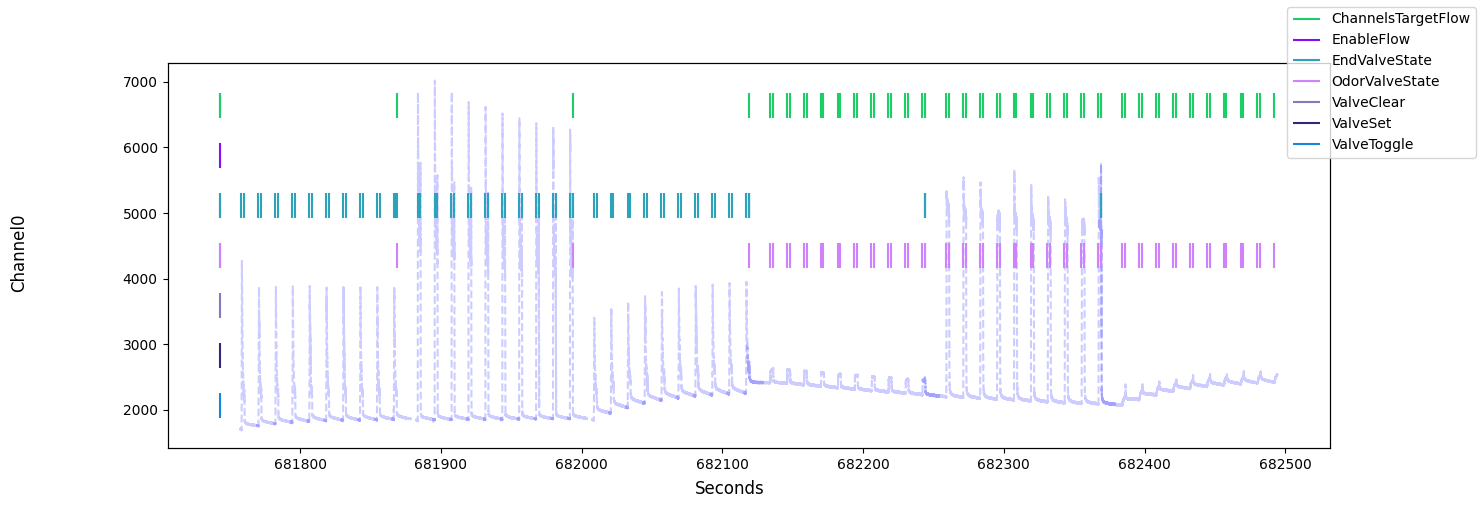

In [25]:
random.seed(123)
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

in_list = [ChannelsTargetFlow, EnableFlow, EndValveState, OdorValveState, ValveClear, ValveSet, ValveToggle]
in_list_lab = ['ChannelsTargetFlow', 'EnableFlow', 'EndValveState', 'OdorValveState', 'ValveClear', 'ValveSet', 'ValveToggle']
offsets = 12

fig, ax1 = plt.subplots(figsize = (15,5))

for i, v in valve_status.iterrows():
    ax1.plot(v['seconds'], v['data'], color = 'b', alpha = .2, linestyle = '--')

ax2 = ax1.twinx()

for j in range(len(in_list)):
    tmp_val = np.array(in_list[j].index.tolist())
    ax2.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), label = in_list_lab[j])
    offsets -= 2

ax2.set_yticks([])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
fig.supylabel('Channel0')
fig.supxlabel('Seconds')
fig.show()

In [26]:
valve_status = valve_status[['IsEndValveCalibration', 'channel_index', 'odorant', 'trial_count', 'time_valve_open', 'time_valve_closed', 'seconds', 'data']]
valve_status = valve_status[valve_status['IsEndValveCalibration'] == True]

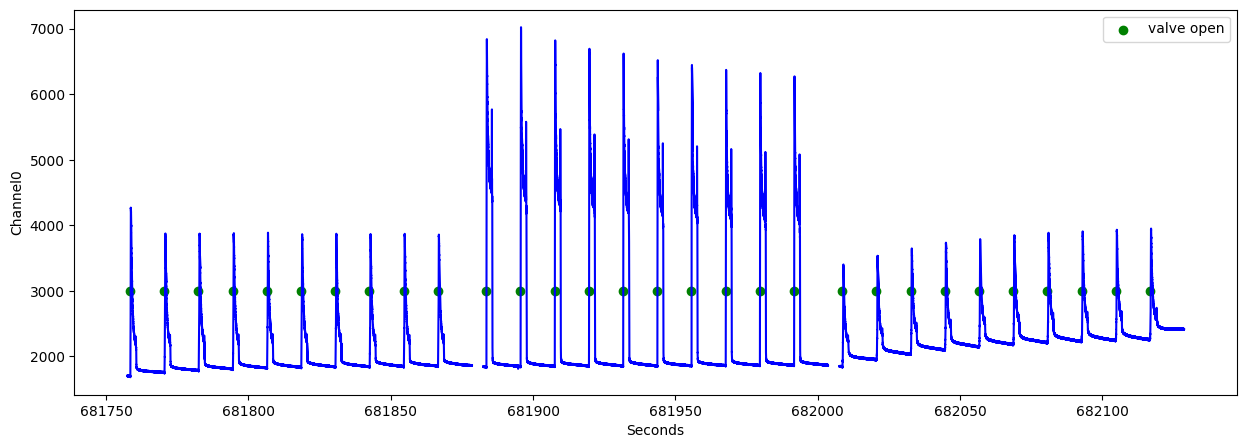

In [27]:
plt.figure(figsize=(15,5))
for i, v in valve_status.iterrows():
    plt.plot(v['seconds'], v['data'], color = 'b')
    plt.scatter(v['time_valve_open'], 3000, color = 'g', label = 'valve open')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('Channel0')
plt.xlabel('Seconds')
plt.show()

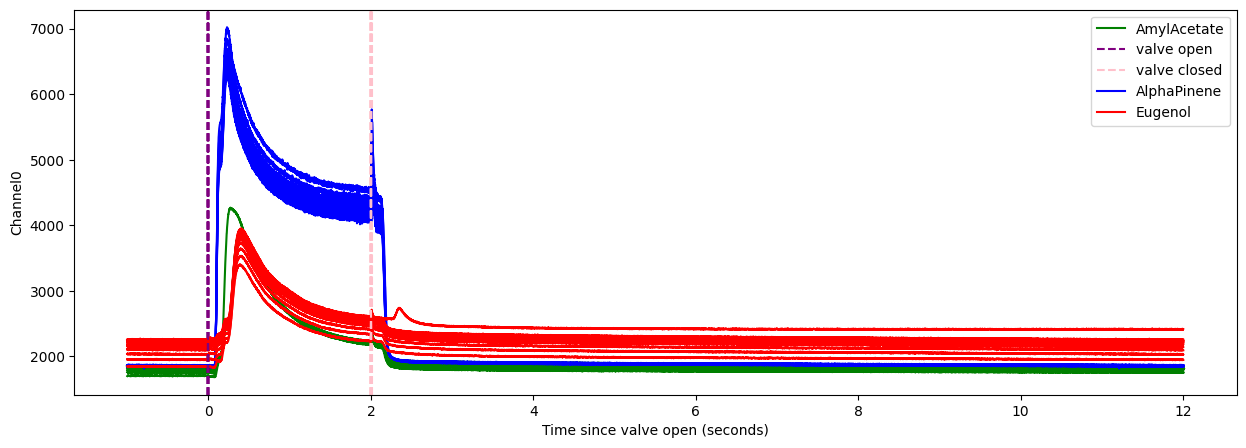

In [28]:
plt.figure(figsize=(15,5))
for i, v in valve_status.iloc[0:30].iterrows():
    if v['channel_index'] == 0:
        col = 'r'
        lab = 'Eugenol'
    elif v['channel_index'] == 1:
        col = 'b'
        lab = 'AlphaPinene'
    else:
        col = 'g'
        lab = 'AmylAcetate'
    
    plt.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = col, label = lab)
    plt.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = '--', label = 'valve open')
    plt.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = '--', label = 'valve closed')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('Channel0')
plt.xlabel('Time since valve open (seconds)')
    
plt.show()

In [29]:
valve_status.head()

,IsEndValveCalibration,channel_index,odorant,trial_count,time_valve_open,time_valve_closed,seconds,data
0,True,2,AmylAcetate,1,681758.408480,681760.412480,"[681757.408992, 681757.409984, 681757.410976, ...","[1699, 1703, 1704, 1703, 1705, 1707, 1705, 170..."
1,True,2,AmylAcetate,2,681770.422496,681772.423488,"[681769.422976, 681769.424, 681769.424992, 681...","[1758, 1757, 1759, 1758, 1763, 1757, 1756, 175..."
2,True,2,AmylAcetate,3,681782.435488,681784.446496,"[681781.436, 681781.436992, 681781.437984, 681...","[1790, 1792, 1789, 1786, 1782, 1789, 1788, 178..."
3,True,2,AmylAcetate,4,681794.456480,681796.458496,"[681793.456992, 681793.457984, 681793.458976, ...","[1810, 1812, 1812, 1810, 1811, 1808, 1812, 181..."
4,True,2,AmylAcetate,5,681806.473504,681808.474496,"[681805.473984, 681805.474976, 681805.476, 681...","[1830, 1830, 1829, 1830, 1836, 1828, 1828, 182..."


### Interpolating data

In [30]:
valve_interpolate = valve_status.copy()

In [31]:
def interpolate(inp, fi):
    i, f = int(fi // 1), fi % 1  # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * inp[i] + f * inp[j]

In [32]:
def interpolate_col(col_name, max_len):
    output = []
    
    for i in valve_interpolate[col_name]:
        inp = i
        delta = (len(inp) - 1) / (max_len - 1)
        output.append([interpolate(inp, j*delta) for j in range(max_len)])
    return output

In [33]:
outp = interpolate_col('data', 4011)
outp_time = interpolate_col('seconds', 4011)

In [34]:
valve_interpolate['data'] = outp
valve_interpolate['seconds'] = outp_time

### Calculate mean group by odorant

In [35]:
valve_odo_mean = valve_interpolate[valve_interpolate['IsEndValveCalibration'] == True].\
    groupby(['channel_index', 'odorant'], as_index= False).\
        agg(
            mean_time_valve_open = ('time_valve_open', 'mean'),
            mean_time_valve_closed = ('time_valve_closed', 'mean')
        )

valve_odo_mean['mean_seconds'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['seconds'])], include_groups = False)
valve_odo_mean['mean_data'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['data'])], include_groups = False)

In [36]:
def normalize_col():
    mean_seconds_norm = []
    mean_data_norm = []

    for i, v in valve_odo_mean.iterrows():
        mean_seconds_norm.append([x - v['mean_time_valve_open'] for x in v['mean_seconds']])
        mean_data_norm.append([x - v['mean_data'][0] for x in v['mean_data']])
    valve_odo_mean['mean_seconds_norm'] = mean_seconds_norm
    valve_odo_mean['mean_data_norm'] = mean_data_norm
    
    return valve_odo_mean

valve_odo_mean = normalize_col()
valve_odo_mean

,channel_index,odorant,mean_time_valve_open,mean_time_valve_closed,mean_seconds,mean_data,mean_seconds_norm,mean_data_norm
0,0,Eugenol,682062.726186,682064.727901,"[682061.7266912, 682061.7299344831, 682061.733...","[2124.3, 2124.2628179551125, 2122.088179551122...","[-0.9994943999918178, -0.9962511169724166, -0....","[0.0, -0.03718204488768606, -2.211820448877915..."
1,1,AlphaPinene,681937.603789,681939.606096,"[681936.6042879999, 681936.6075338565, 681936....","[1857.8, 1857.775211970075, 1857.9631920199504...","[-0.9995008000405505, -0.9962549434276298, -0....","[0.0, -0.02478802992504825, 0.1631920199504293..."
2,2,AmylAcetate,681812.475008,681814.477891,"[681811.475488, 681811.4787340122, 681811.4819...","[1812.5, 1813.1443391521195, 1812.195610972568...","[-0.9995200000703335, -0.9962739878101274, -0....","[0.0, 0.6443391521195281, -0.30438902743162544..."


### Graphing

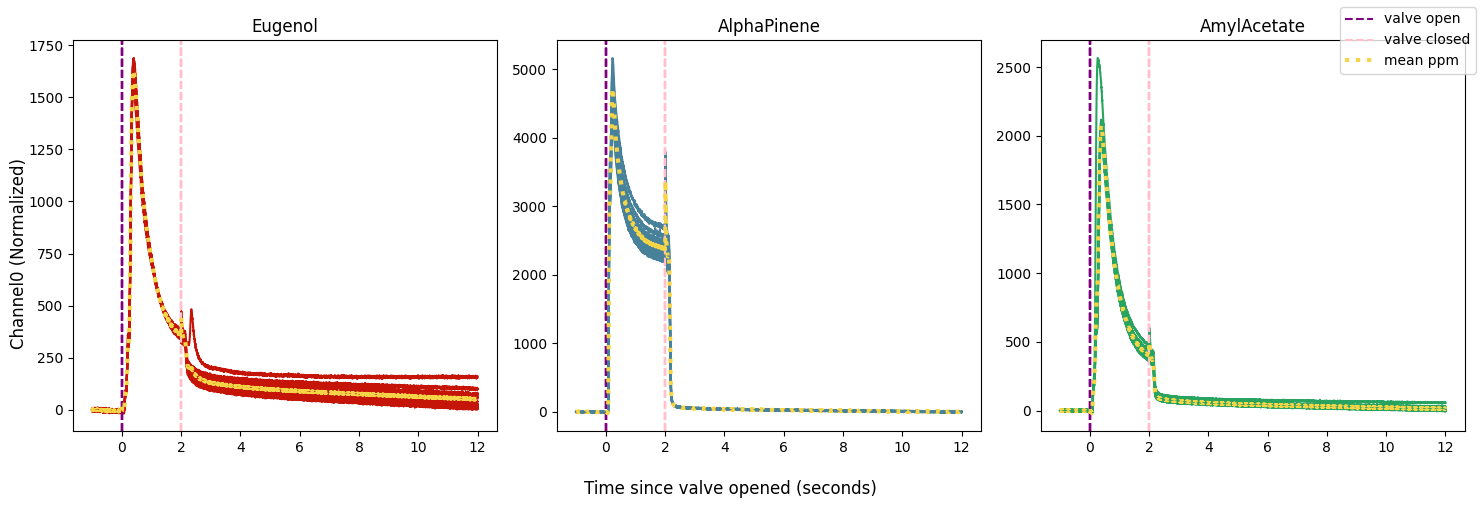

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508')
    ax1.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'valve open')
    ax1.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'valve closed')
    ax1.set_title("Eugenol")
    
ax1.plot(valve_odo_mean['mean_seconds_norm'][0], valve_odo_mean['mean_data_norm'][0], color = '#F5D547', linestyle = 'dotted', linewidth = 3, label = 'mean ppm')    

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#47829A')
    ax2.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'valve open')
    ax2.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'valve closed')
    ax2.set_title("AlphaPinene")

ax2.plot(valve_odo_mean['mean_seconds_norm'][1], valve_odo_mean['mean_data_norm'][1], color = '#F5D547', linestyle = 'dotted', linewidth = 3, label = 'mean ppm')
    
for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#28A460')
    ax3.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'valve open')
    ax3.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'valve closed')
    ax3.set_title("AmylAcetate")

ax3.plot(valve_odo_mean['mean_seconds_norm'][2], valve_odo_mean['mean_data_norm'][2], color = '#F5D547', linestyle = 'dotted', linewidth = 3, label = 'mean ppm')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
fig.supxlabel('Time since valve opened (seconds)')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout()

### Calculate t-ON at quantile: .5, .75, .95, 1

In [38]:
def get_quantile(df):
    small_list = []
    output_list = []
    
    for i in range(len(df)):
        index_data = df['data'][i]
        index_sec = df['seconds'][i]
        max_val = max(index_data)
        
        time_at_max = index_sec[index_data.index(max_val)]
        
        for t in [.50, .75, .90, 1]:
            time_at_t = np.quantile(
                [j for j in index_sec \
                    if j >= df['time_valve_open'][i] and \
                        j <= time_at_max],
                
                t
            )
            
            small_list.append(time_at_t)
            
            if len(small_list) == 4:
                output_list.append(small_list)
                small_list = []
                
    return output_list

In [39]:
valve_status.insert(valve_status.shape[1], 't_ON_quantile', get_quantile(valve_status), True) #order: .50 > .75 > .95 > 1

### Calculate t-ON

In [40]:
def fiveX_SD(data, col_on, col_off, threshold_ex):
    output_list = []
    
    for i in range(len(data)):
        x = data['seconds'][i]
        y = data['data'][i]
        time_on = data[col_on][i]
        time_off = data[col_off][i]
        
        df = pd.DataFrame({'y': y}, index = x)
        
        df_baseline = df[df.index <= time_on]
        
        baseline_sd = stats.stdev(df_baseline['y'])
        threshold = threshold_ex * baseline_sd
        
        win_size = 400 #int(len(df) * 10 / 100)
        
        df = df[df.index <= time_off]
        
        sd_roll = df.rolling(win_size).std()
        
        for j in sd_roll.values:
            if j >= threshold:
                output_val = sd_roll.index[sd_roll['y'] == j[0]][0]
                output_list.append(output_val)
                
                break
    
    return output_list

In [41]:
valve_status.insert(valve_status.shape[1], "t_ON_5xSD", fiveX_SD(valve_status, 'time_valve_open', 'time_valve_closed', 5), True)

### Calculate t-OFF

In [42]:
def fiveX_revSD(data, col_on, col_off):
    output_list = []
    
    for i in range(len(data)):
        x = data['seconds'][i]
        y = data['data'][i]
        time_off = data[col_off][i]
        time_on = data[col_on][i]
                                      
        df = pd.DataFrame({'y': y}, index = x)
        baseline_sd = stats.stdev(df[df.index <= time_on]['y'])
        win_size = 400 #int(len(df) * 10 / 100)
        df = df[df.index >= time_off]
        
        df_rev = df.iloc[::-1]
        
        df_roll = df_rev.rolling(win_size).std().dropna()
        
        
        threshold = baseline_sd * 2
        
        for j in df_roll.values:
            if j >= threshold:
                output_val = df_roll.index[df_roll['y'] == j[0]][0]
                output_list.append(output_val)
                
                break
    return output_list

In [43]:
valve_status.insert(valve_status.shape[1], 't_OFF_5xSD', fiveX_revSD(valve_status, 'time_valve_open', 'time_valve_closed'), True)

c:\Users\huy.nguyen\Documents\AIND Services\Aind.Behavior.Services\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_14800\714763495.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


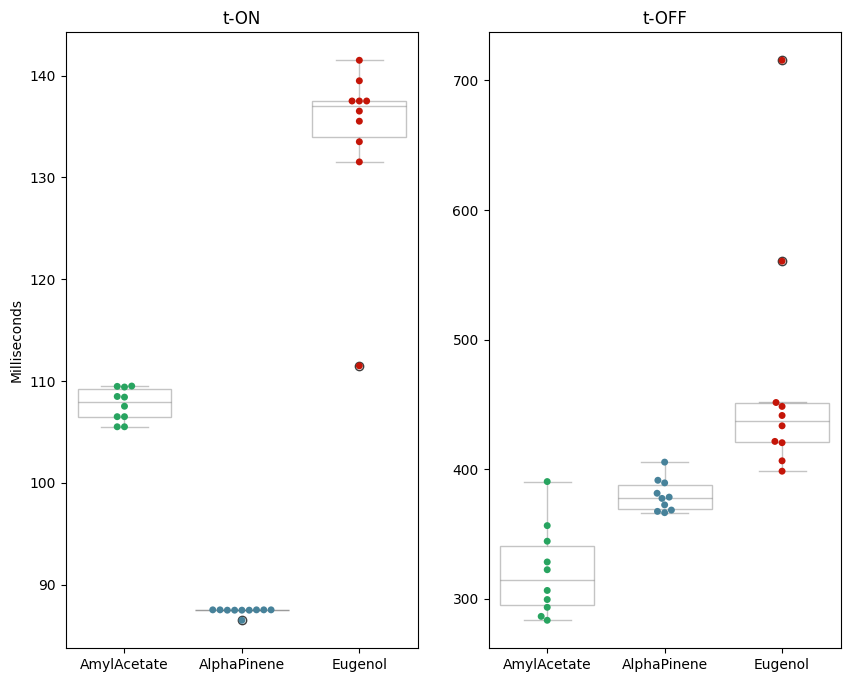

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}
sns.swarmplot(x = 'odorant', y = (valve_status['t_ON_5xSD'] - valve_status['time_valve_open']) * 1000, hue = 'odorant', data = valve_status, ax=ax1).\
    set(xlabel = None, ylabel = 'Milliseconds', title = 't-ON')
sns.boxplot(x = 'odorant', y = (valve_status['t_ON_5xSD'] - valve_status['time_valve_open']) * 1000, data = valve_status, **PROPS, ax=ax1).\
    set(xlabel = None, ylabel = 'Milliseconds')

sns.swarmplot(x = 'odorant', y = (valve_status['t_OFF_5xSD'] - valve_status['time_valve_closed']) * 1000, hue = 'odorant', data = valve_status, ax = ax2).\
    set(xlabel = None, ylabel = None, title = 't-OFF')
sns.boxplot(x = 'odorant', y = (valve_status['t_OFF_5xSD'] - valve_status['time_valve_closed']) * 1000, data = valve_status, **PROPS, ax = ax2).\
    set(xlabel = None, ylabel = None)

fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

### Difference between end and start

In [45]:
def delta_amp(data, col_on, col_off):
    output_list = []
    
    for i in range(len(data)):
        x = data['seconds'][i]
        y = data['data'][i]
        time_on = data[col_on][i]
        time_off = data[col_off][i]
        
        df = pd.DataFrame({'y': y}, index = x)
        
        start = np.mean(df[df.index <= time_on]['y'])
        end = np.mean(df[df.index >= (time_off + 9)])
        
        output_list.append(end - start)
    
    return output_list

In [46]:
delta_df = pd.DataFrame({'y': delta_amp(valve_status, 'time_valve_open', 'time_valve_closed')})
delta_df['odorant'] = 'A'
delta_df.loc[(delta_df.index >= 0) & (delta_df.index < 10), 'odorant'] = 'AmylAcetate'
delta_df.loc[(delta_df.index >= 10) & (delta_df.index < 20), 'odorant'] = 'AlphaPinene'
delta_df.loc[(delta_df.index >= 20), 'odorant'] = 'Eugenol'
delta_df = delta_df.reset_index()

Text(0.5, 0.98, 'ppm difference before valve open and\n the 10th second after valve closed')

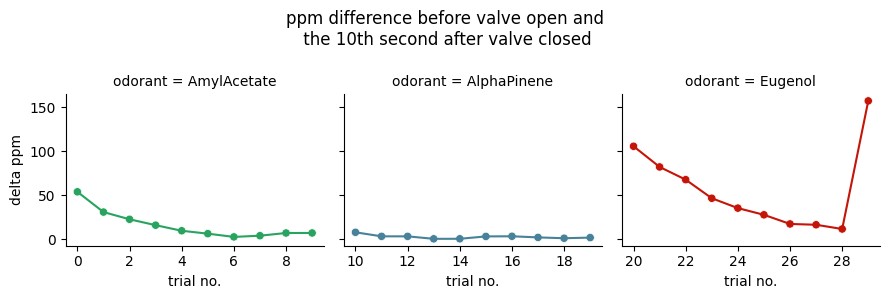

In [47]:
g = sns.FacetGrid(delta_df, col = 'odorant', sharex = False, margin_titles = True)
g.map(sns.lineplot, 'index', 'y', data = delta_df, hue = 'odorant').\
    map(sns.scatterplot, 'index', 'y', data = delta_df, hue = 'odorant').\
    set(xlabel = 'trial no.', ylabel = 'delta ppm')

g.fig.subplots_adjust(top=0.7)
g.fig.suptitle('ppm difference before valve open and\n the 10th second after valve closed')


### Calculate integral

In [48]:
def integral_simpson(data, col_on, col_off):
    output_list = []
    
    for i in range(len(data)):
        x_val = data['seconds'][i]
        y_val = data['data'][i]
        time_on = data[col_on][i]
        time_off = data[col_off][i]
        
        df = pd.DataFrame({'y': y_val}, index = x_val)
        
        filtered_df = df['y'][(df.index >= time_on) & (df.index <= time_off)]
        
        simpson_val = simpson(y = filtered_df.values, x = filtered_df.index)
        
        output_list.append(simpson_val)
    
    return output_list

In [49]:
valve_status.insert(valve_status.shape[1], "integral_simpson", integral_simpson(valve_status, 'time_valve_open', 'time_valve_closed'), True)

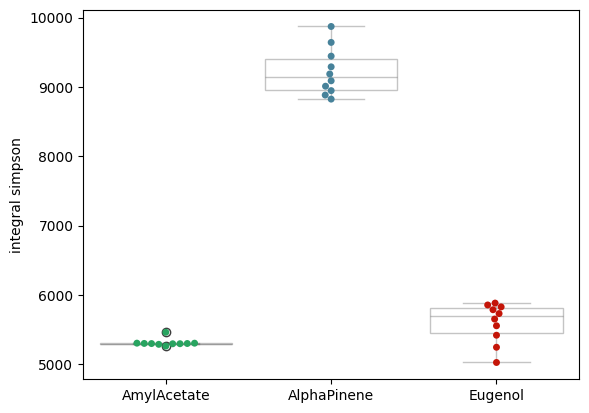

In [50]:
PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}

sns.swarmplot(x = 'odorant', y = 'integral_simpson', hue = 'odorant', data = valve_status).\
    set(xlabel = None, ylabel = 'integral simpson')

sns.boxplot(x = 'odorant', y = 'integral_simpson', data = valve_status, **PROPS).\
    set(xlabel = None, ylabel = 'integral simpson')



plt.show()

### Get First Bump

In [51]:
def get_bump(data, col_on, prominence):
    
    output_list = []
    
    for i in range(len(data)):
        x = data['seconds'][i]
        y = data['data'][i]
        time_valve_open = data[col_on][i]
        
        df = pd.DataFrame({'y': y}, index = x) 
        df = df[(df.index >= time_valve_open) & (df.index <= df.idxmax().iloc[0])]
        
        win_size = int(len(df) * 10 / 100)
        df_roll_def = df.rolling(win_size).var() ; df_roll = np.array(df_roll_def['y'])
        
        peaks, _ = find_peaks(df_roll, prominence= prominence)
        
        output = df_roll_def.index[df_roll_def['y'] == df_roll[peaks][0]][0]
        output_list.append(output)
        
    return output_list

In [52]:
valve_status.insert(valve_status.shape[1], "first_bump", get_bump(valve_status, 'time_valve_open', 100), True)

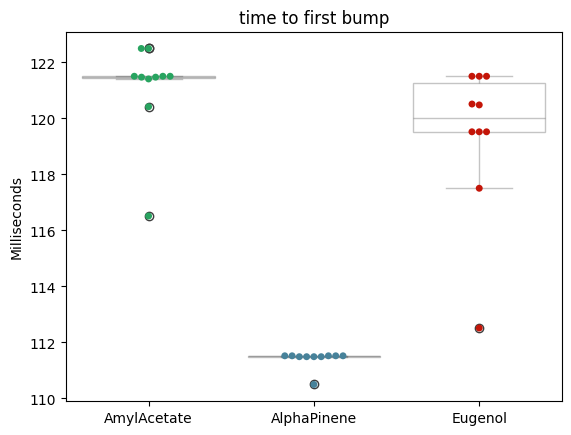

In [53]:
PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}

ax = sns.swarmplot(x = 'odorant', y = (valve_status['first_bump'] - valve_status['time_valve_open']) * 1000, hue = 'odorant', data = valve_status).\
    set(xlabel = None, ylabel = 'Milliseconds', title = 'time to first bump')
ax = sns.boxplot(x = 'odorant', y = (valve_status['first_bump'] - valve_status['time_valve_open']) * 1000, data = valve_status, **PROPS).\
    set(xlabel = None, ylabel = 'Milliseconds')

plt.show()

## IsEndValveCalibration == False

In [54]:
mixture_sum = (mixture['Channel0'] + mixture['Channel1'] + mixture['Channel2'])

In [55]:
mixture_0 = mixture_sum.loc[mixture_sum.values == 0]
mixture_100 = mixture_sum.loc[mixture_sum.values == 100]

print(f"mixture_0 | length: {len(mixture_0)}\n{mixture_0.head(5)}")
print()
print(f"mixture_100 | length: {len(mixture_100)}\n{mixture_100.head(5)}")

mixture_0 | length: 32
Time
682118.775520    0.0
682135.812544    0.0
682147.817536    0.0
682159.830528    0.0
682171.845536    0.0
dtype: float32

mixture_100 | length: 34
Time
681743.395520    100.0
681743.411488    100.0
681868.536544    100.0
681993.661536    100.0
682133.807520    100.0
dtype: float32


In [56]:
mix_status = pd.concat(
    [pd.DataFrame({'time_on' : mixture_100.index.tolist()[4:(len(mixture_100) -1)]}), #chop two rows to sync up data.
    pd.DataFrame({'time_off': pd.Series(mixture_0.index.tolist()).iloc[np.r_[1:10, 11:21, 22:(len(mixture_0))].tolist()].tolist()})],
    ignore_index= True,
    axis= 1
).\
    rename(columns={0: 'time_mixture_on', 1: 'time_mixture_off'})

In [57]:
mix_status.loc[mix_status['time_mixture_on'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
mix_status.loc[mix_status['time_mixture_on'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [58]:
def extract_mix_trial(type_val):
    big_list = []
    for i in range(len(mix_status)):
        if type_val == 'data':
                
            big_list.append(
                nu_analog.values[(mix_status['time_mixture_on'][i] - 1 <= nu_analog.index) & (nu_analog.index <= mix_status['time_mixture_off'][i] + 10)].tolist()
            )
                
        elif type_val == 'seconds':
            big_list.append(
                nu_analog.index[(mix_status['time_mixture_on'][i] - 1 <= nu_analog.index) & (nu_analog.index <= mix_status['time_mixture_off'][i] + 10)].tolist()
            )
    
    return big_list

In [59]:
mix_status['data'] = extract_mix_trial('data')
mix_status['seconds'] = extract_mix_trial('seconds')

In [60]:
mix_status['odorant'] = get_odor_list(mix_status['time_mixture_on'])
get_odor_list(mix_status['time_mixture_on'])
mix_status = mix_status.merge(odor_config.iloc[0:3,:], on = 'odorant', how = 'left')

In [61]:
mix_status['trial_count'] = mix_status.groupby(['channel_index', 'IsEndValveCalibration']).cumcount() + 1
mix_status = mix_status[['IsEndValveCalibration', 'channel_index', 'odorant', 'trial_count', 'time_mixture_on', 'time_mixture_off', 'seconds', 'data']]

### Graphing

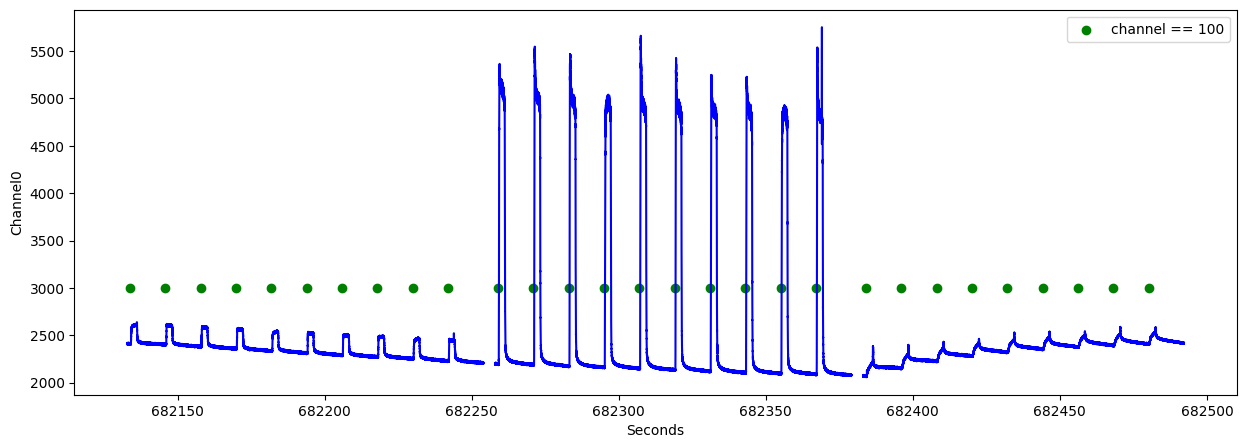

In [62]:
plt.figure(figsize=(15,5))
for i, v in mix_status.iterrows():
    plt.plot(v['seconds'], v['data'], color = 'b')
    plt.scatter(v['time_mixture_on'], 3000, color = 'g', label = 'channel == 100')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('Channel0')
plt.xlabel('Seconds')
plt.show()

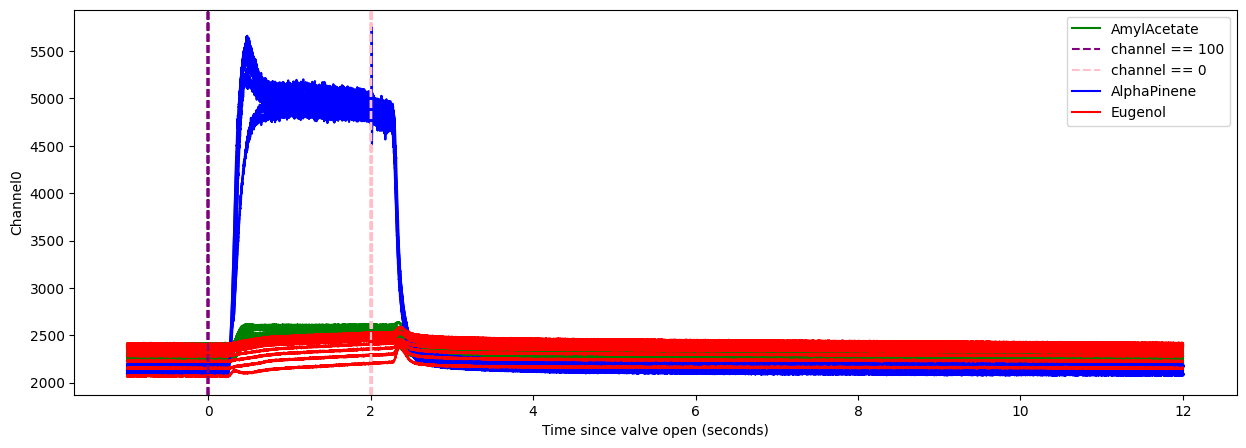

In [63]:
plt.figure(figsize=(15,5))
for i, v in mix_status.iloc[0:30].iterrows():
    if v['channel_index'] == 0:
        col = 'r'
        lab = 'Eugenol'
    elif v['channel_index'] == 1:
        col = 'b'
        lab = 'AlphaPinene'
    else:
        col = 'g'
        lab = 'AmylAcetate'
    
    plt.plot([x - v['time_mixture_on'] for x in v['seconds']], v['data'], color = col, label = lab)
    plt.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = '--', label = 'channel == 100')
    plt.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = '--', label = 'channel == 0')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('Channel0')
plt.xlabel('Time since valve open (seconds)')
    
plt.show()

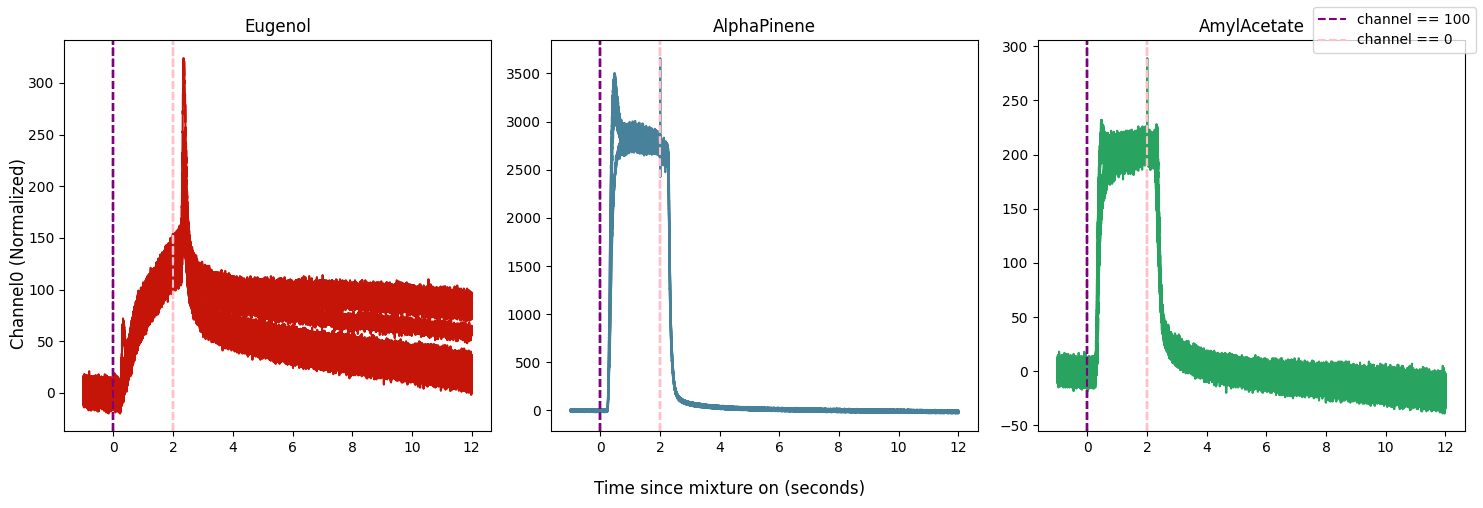

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in mix_status[(mix_status['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_mixture_on'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508')
    ax1.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'channel == 100')
    ax1.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'channel == 0')
    ax1.set_title("Eugenol")  

for i, v in mix_status[(mix_status['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_mixture_on'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#47829A')
    ax2.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'channel == 100')
    ax2.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'channel == 0')
    ax2.set_title("AlphaPinene")
    
for i, v in mix_status[(mix_status['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_mixture_on'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#28A460')
    ax3.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'channel == 100')
    ax3.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'channel == 0')
    ax3.set_title("AmylAcetate")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
fig.supxlabel('Time since mixture on (seconds)')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout()

### Calculate t-ON

In [65]:
mix_status.insert(mix_status.shape[1], "t_ON_5xSD", fiveX_SD(mix_status, 'time_mixture_on', 'time_mixture_off', 3), True)

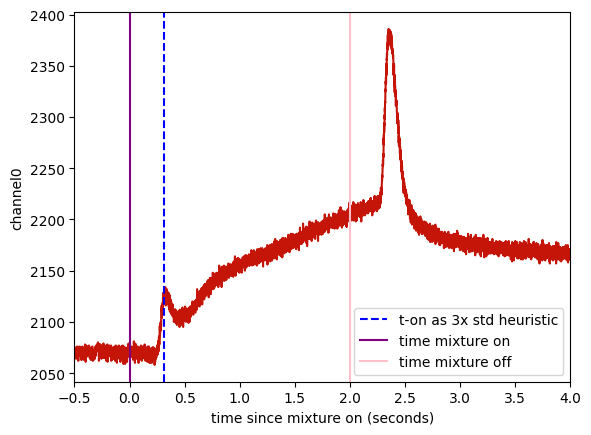

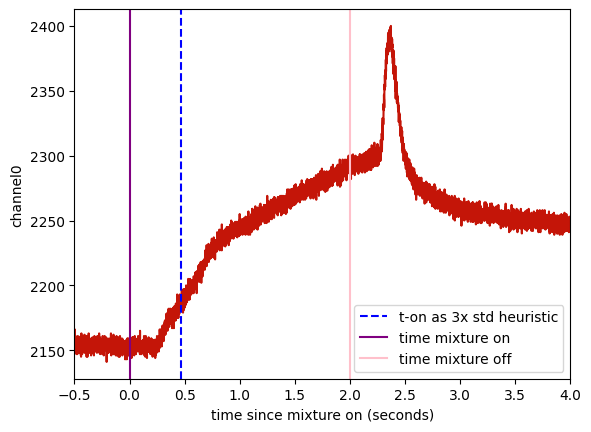

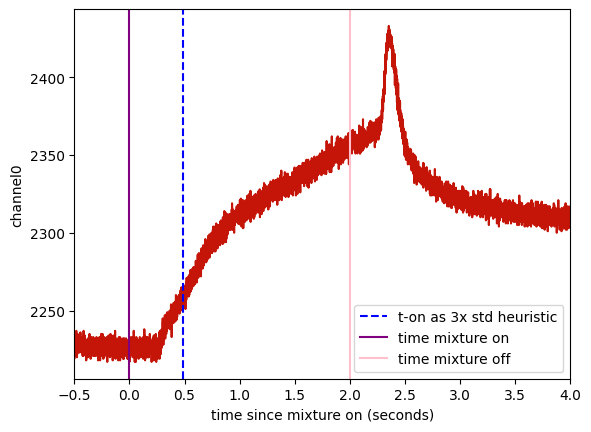

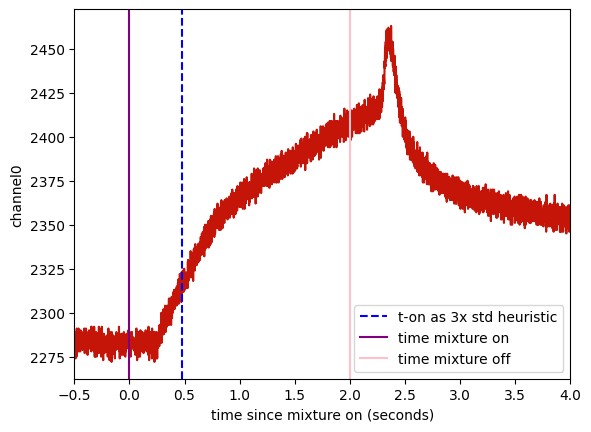

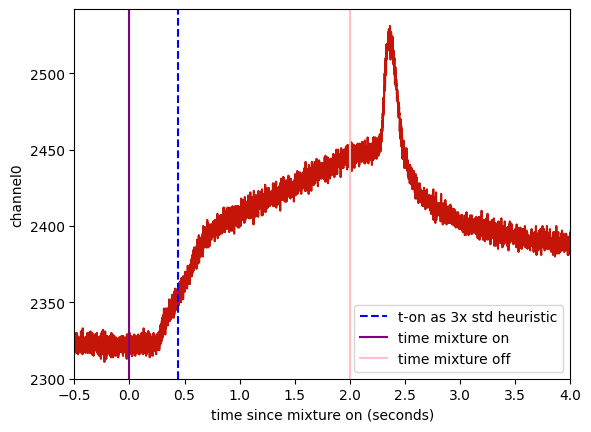

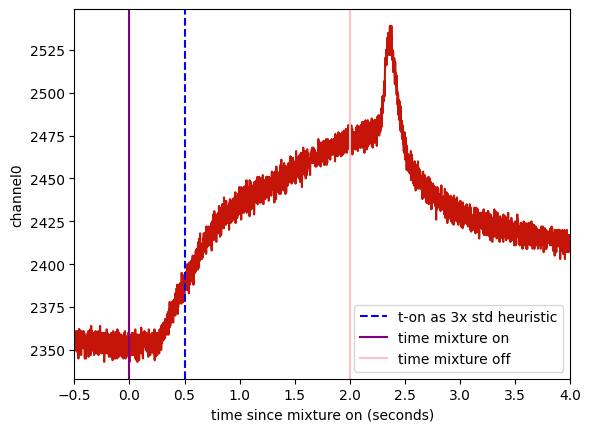

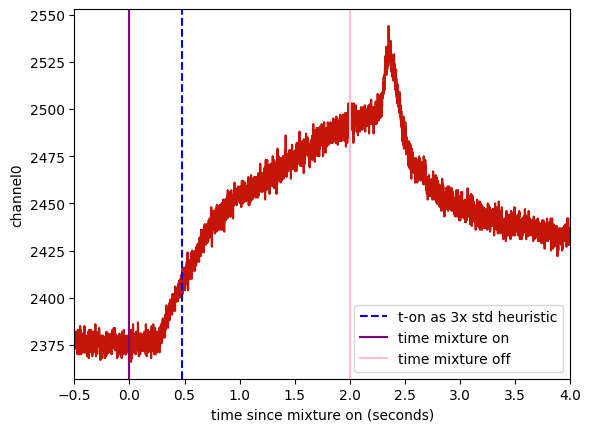

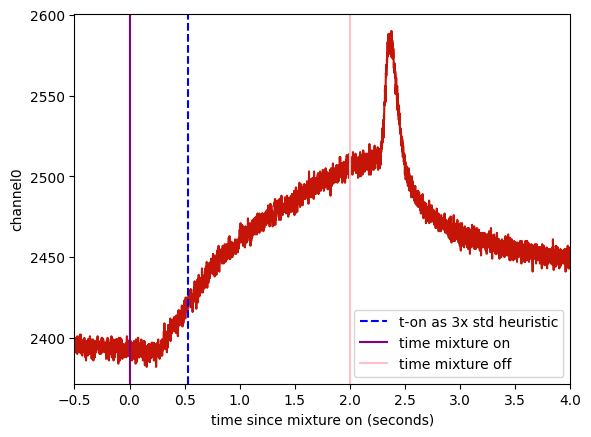

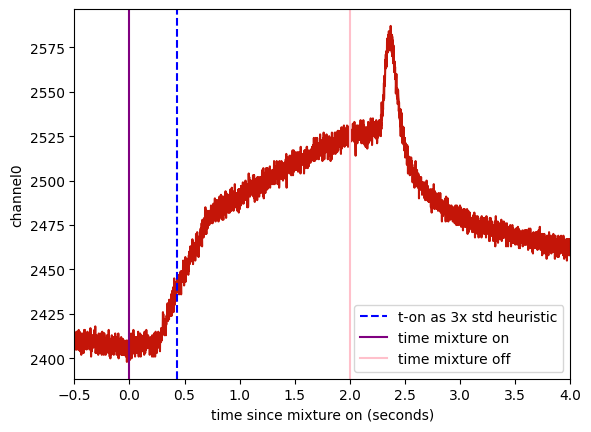

In [66]:
for i in range(20, 29):
    plt.figure()
    plt.plot([x - mix_status['time_mixture_on'][i] for x in mix_status['seconds'][i]], mix_status['data'][i], color = '#C41508')
    plt.axvline(mix_status['t_ON_5xSD'][i] - mix_status['time_mixture_on'][i], color = 'b', linestyle = '--', label = 't-on as 3x std heuristic')
    plt.axvline(mix_status['time_mixture_on'][i] - mix_status['time_mixture_on'][i], color = 'purple', label = 'time mixture on')
    plt.axvline(mix_status['time_mixture_off'][i] - mix_status['time_mixture_on'][i], color = 'pink', label = 'time mixture off')
    plt.xlim(-.5, 4)
    plt.legend()
    plt.xlabel('time since mixture on (seconds)')
    plt.ylabel('channel0')
    plt.show()

### Calculate t-OFF

In [67]:
mix_status.insert(mix_status.shape[1], 't_OFF_5xSD', fiveX_revSD(mix_status, 'time_mixture_on', 'time_mixture_off'), True)

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_14800\3669593408.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


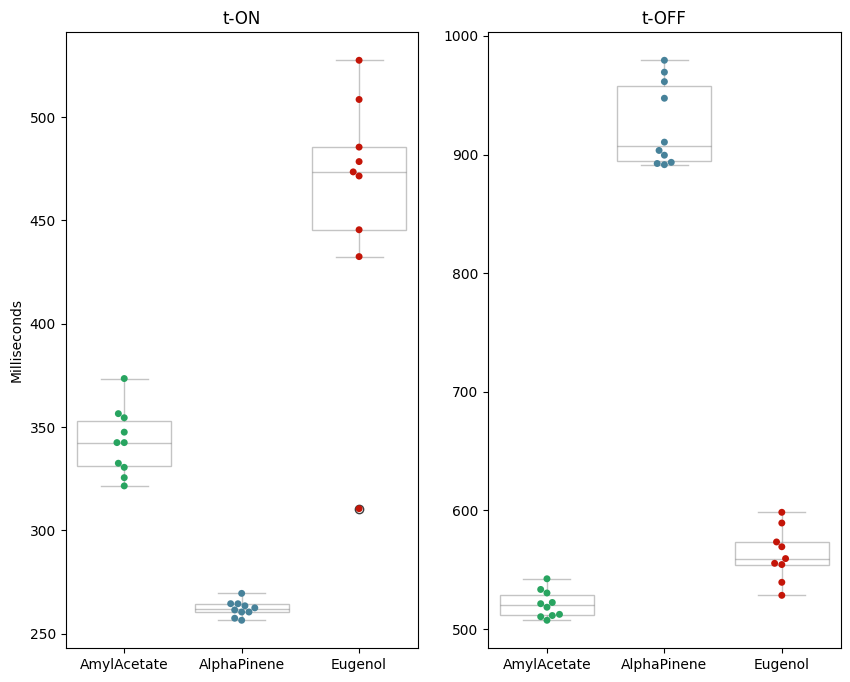

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)

PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}
sns.swarmplot(x = 'odorant', y = (mix_status['t_ON_5xSD'] - mix_status['time_mixture_on']) * 1000, hue = 'odorant', data = mix_status, ax=ax1).\
    set(xlabel = None, ylabel = 'Milliseconds', title = 't-ON')
sns.boxplot(x = 'odorant', y = (mix_status['t_ON_5xSD'] - mix_status['time_mixture_on']) * 1000, data = mix_status, **PROPS, ax=ax1).\
    set(xlabel = None, ylabel = 'Milliseconds')

sns.swarmplot(x = 'odorant', y = (mix_status['t_OFF_5xSD'] - mix_status['time_mixture_off']) * 1000, hue = 'odorant', data = mix_status, ax = ax2).\
    set(xlabel = None, ylabel = None, title = 't-OFF')
sns.boxplot(x = 'odorant', y = (mix_status['t_OFF_5xSD'] - mix_status['time_mixture_off']) * 1000, data = mix_status, **PROPS, ax = ax2).\
    set(xlabel = None, ylabel = None)

fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

### Difference between end and start

In [69]:
delta_df_m = pd.DataFrame({'y': delta_amp(mix_status, 'time_mixture_on', 'time_mixture_off')})
delta_df_m['odorant'] = 'A'
delta_df_m.loc[(delta_df_m.index >= 0) & (delta_df_m.index < 10), 'odorant'] = 'AmylAcetate'
delta_df_m.loc[(delta_df_m.index >= 10) & (delta_df_m.index < 20), 'odorant'] = 'AlphaPinene'
delta_df_m.loc[(delta_df_m.index >= 20), 'odorant'] = 'Eugenol'
delta_df_m = delta_df_m.reset_index()

Text(0.5, 0.98, 'ppm difference before valve open and\n the 10th second after valve closed')

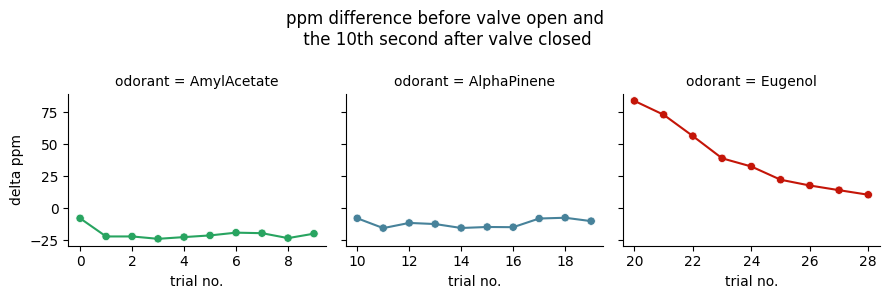

In [70]:
g = sns.FacetGrid(delta_df_m, col = 'odorant', sharex = False, margin_titles = True)
g.map(sns.lineplot, 'index', 'y', data = delta_df, hue = 'odorant').\
    map(sns.scatterplot, 'index', 'y', data = delta_df_m, hue = 'odorant').\
    set(xlabel = 'trial no.', ylabel = 'delta ppm')

g.fig.subplots_adjust(top=0.7)
g.fig.suptitle('ppm difference before valve open and\n the 10th second after valve closed')


### Calculate integral

In [71]:
mix_status.insert(mix_status.shape[1], "integral_simpson", integral_simpson(mix_status, 'time_mixture_on', 'time_mixture_off'), True)

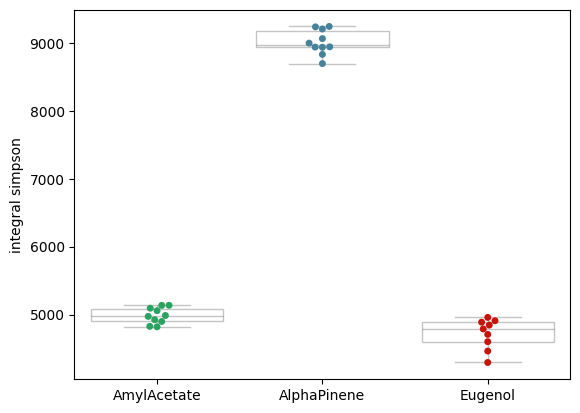

In [72]:
PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}

sns.swarmplot(x = 'odorant', y = 'integral_simpson', hue = 'odorant', data = mix_status).\
    set(xlabel = None, ylabel = 'integral simpson')

sns.boxplot(x = 'odorant', y = 'integral_simpson', data = mix_status, **PROPS).\
    set(xlabel = None, ylabel = 'integral simpson')

plt.show()

### Get First Bump

In [73]:
mix_status.insert(mix_status.shape[1], "first_bump", get_bump(mix_status, 'time_mixture_on', 10), True)

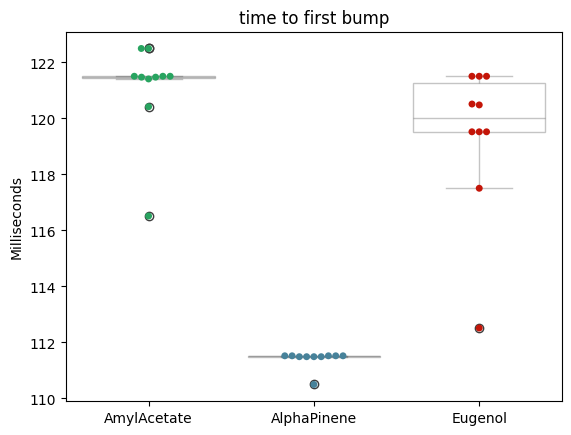

In [74]:
PROPS = {
    'boxprops' :{'facecolor':'None', 'alpha': 0.3},
    'medianprops' : {'alpha': 0.3},
    'whiskerprops' : {'alpha': 0.3},
    'capprops':{'alpha': 0.3}
}

ax = sns.swarmplot(x = 'odorant', y = (valve_status['first_bump'] - valve_status['time_valve_open']) * 1000, hue = 'odorant', data = valve_status).\
    set(xlabel = None, ylabel = 'Milliseconds', title = 'time to first bump')
ax = sns.boxplot(x = 'odorant', y = (valve_status['first_bump'] - valve_status['time_valve_open']) * 1000, data = valve_status, **PROPS).\
    set(xlabel = None, ylabel = 'Milliseconds')

plt.show()

## Overlaying EndValCal == T and EndValCal == F

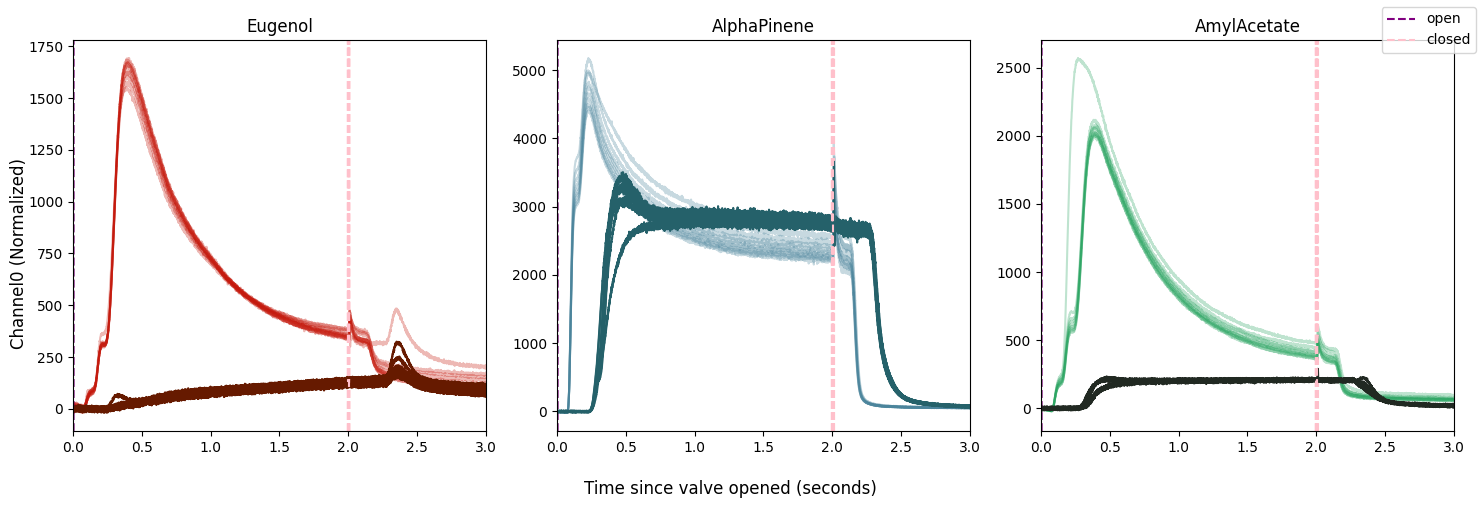

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_status[(valve_status['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508', alpha = .3)
    ax1.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax1.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax1.set_title("Eugenol")
    ax1.set_xlim(0,3)

for i, v in mix_status[(mix_status['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_mixture_on'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#661A00')
    ax1.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax1.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax1.set_title("Eugenol")
    ax1.set_xlim(0,3)
    
for i, v in valve_status[(valve_status['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#47829A', alpha = .3)
    ax2.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax2.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax2.set_title("AlphaPinene")
    ax2.set_xlim(0,3)
    
for i, v in mix_status[(mix_status['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_mixture_on'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#25616A')
    ax2.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax2.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax2.set_title("AlphaPinene")
    ax2.set_xlim(0,3)
    
for i, v in valve_status[(valve_status['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#28A460', alpha = .3)
    ax3.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax3.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax3.set_title("AmylAcetate")
    ax3.set_xlim(0,3)

for i, v in mix_status[(mix_status['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_mixture_on'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#212922')
    ax3.axvline((v['time_mixture_on'] - v['time_mixture_on']), color = 'purple', linestyle = 'dashed', label = 'open')
    ax3.axvline((v['time_mixture_off'] - v['time_mixture_on']), color = 'pink', linestyle = 'dashed', label = 'closed')
    ax3.set_title("AmylAcetate")
    ax3.set_xlim(0,3)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys())
fig.supxlabel('Time since valve opened (seconds)')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(15)
fig.tight_layout()

## Overlaying Event and Analog

In [76]:
def convertToSeries(dataframe):
    output = pd.DataFrame(dataframe.index)
    
    return output

In [77]:
Channels_TargetFlow = convertToSeries(ChannelsTargetFlow)
Enable_Flow = convertToSeries(EnableFlow)
End_ValeState = convertToSeries(EndValveState)
Odor_ValveState = convertToSeries(OdorValveState)
Valve_Clear = convertToSeries(ValveClear)
Valve_Set = convertToSeries(ValveSet)
Valve_Toggle = convertToSeries(ValveToggle)

In [78]:
def match_events(type):
    channel_list = []
    enFlow_list = []
    enVal_list = []
    odVal_list = []
    valClear_list = []
    valSet_list = []
    valTog_list = []
        
    if type == 1:
        for i in range(len(valve_status)):
            channel_var = Channels_TargetFlow.loc[Channels_TargetFlow['Time'] < cali_val.index[3]]
            enFlow_var = Enable_Flow.loc[Enable_Flow['Time'] < cali_val.index[3]]
            enVal_var = End_ValeState.loc[End_ValeState['Time'] < cali_val.index[3]]
            odVal_var = Odor_ValveState.loc[Odor_ValveState['Time'] < cali_val.index[3]]
            valClear_var = Valve_Clear.loc[Valve_Clear['Time'] < cali_val.index[3]]
            valSet_var = Valve_Set.loc[Valve_Set['Time'] < cali_val.index[3]]
            valTog_var = Valve_Toggle.loc[Valve_Toggle['Time'] < cali_val.index[3]]
            
            channel_list.append(channel_var.loc[(channel_var['Time'] >= valve_status['time_valve_open'][i]) & (channel_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            enFlow_list.append(enFlow_var.loc[(enFlow_var['Time'] >= valve_status['time_valve_open'][i]) & (enFlow_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            enVal_list.append(enVal_var.loc[(enVal_var['Time'] >= valve_status['time_valve_open'][i]) & (enVal_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            odVal_list.append(odVal_var.loc[(odVal_var['Time'] >= valve_status['time_valve_open'][i]) & (odVal_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            valClear_list.append(valClear_var.loc[(valClear_var['Time'] >= valve_status['time_valve_open'][i]) & (valClear_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            valSet_list.append(valSet_var.loc[(valSet_var['Time'] >= valve_status['time_valve_open'][i]) & (valSet_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
            valTog_list.append(valTog_var.loc[(valTog_var['Time'] >= valve_status['time_valve_open'][i]) & (valTog_var['Time'] <= valve_status['time_valve_closed'][i] + 10), 'Time'].tolist())
    
    elif type == 2:
        for i in range(len(mix_status)):
            channel_var = Channels_TargetFlow.loc[Channels_TargetFlow['Time'] > cali_val.index[2]]
            enFlow_var = Enable_Flow.loc[Enable_Flow['Time'] > cali_val.index[2]]
            enVal_var = End_ValeState.loc[End_ValeState['Time'] > cali_val.index[2]]
            odVal_var = Odor_ValveState.loc[Odor_ValveState['Time'] > cali_val.index[2]]
            valClear_var = Valve_Clear.loc[Valve_Clear['Time'] > cali_val.index[2]]
            valSet_var = Valve_Set.loc[Valve_Set['Time'] > cali_val.index[2]]
            valTog_var = Valve_Toggle.loc[Valve_Toggle['Time'] > cali_val.index[2]]
            
            channel_list.append(channel_var.loc[(channel_var['Time'] >= mix_status['time_mixture_on'][i]) & (channel_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            enFlow_list.append(enFlow_var.loc[(enFlow_var['Time'] >= mix_status['time_mixture_on'][i]) & (enFlow_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            enVal_list.append(enVal_var.loc[(enVal_var['Time'] >= mix_status['time_mixture_on'][i]) & (enVal_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            odVal_list.append(odVal_var.loc[(odVal_var['Time'] >= mix_status['time_mixture_on'][i]) & (odVal_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            valClear_list.append(valClear_var.loc[(valClear_var['Time'] >= mix_status['time_mixture_on'][i]) & (valClear_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            valSet_list.append(valSet_var.loc[(valSet_var['Time'] >= mix_status['time_mixture_on'][i]) & (valSet_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())
            valTog_list.append(valTog_var.loc[(valTog_var['Time'] >= mix_status['time_mixture_on'][i]) & (valTog_var['Time'] <= mix_status['time_mixture_off'][i] + 10), 'Time'].tolist())

    for (a, b) in zip([channel_list, enFlow_list, enVal_list, odVal_list, valClear_list, valSet_list, valTog_list], [channel_var, enFlow_var, enVal_var, odVal_var, valClear_var, valSet_var, valTog_var]):
        if not b.empty:
            a[0].append(b.iloc[0, 0])
        
    output_df = pd.DataFrame({
        'Channels_TargetFlow': channel_list,
        'Enable_Flow': enFlow_list,
        'End_ValeState': enVal_list,
        'Odor_ValveState': odVal_list,
        'Valve_Clear': valClear_list,
        'Valve_Set': valSet_list,
        'Valve_Toggle': valTog_list
    })
        
    return output_df

In [79]:
valve_status = pd.concat([valve_status, match_events(1)], axis = 1)

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_14800\2674453400.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


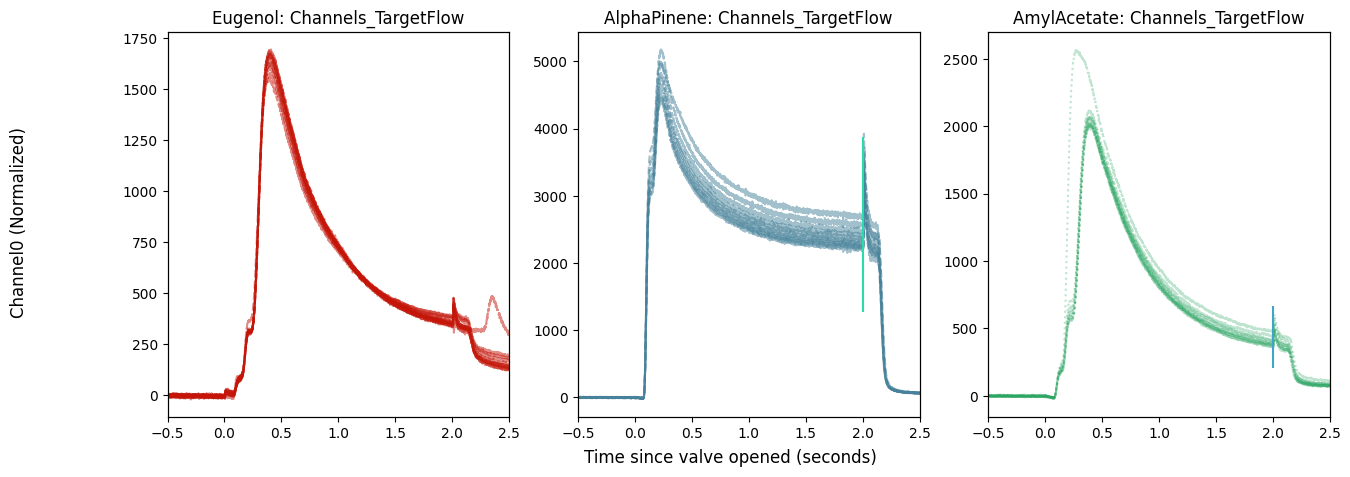

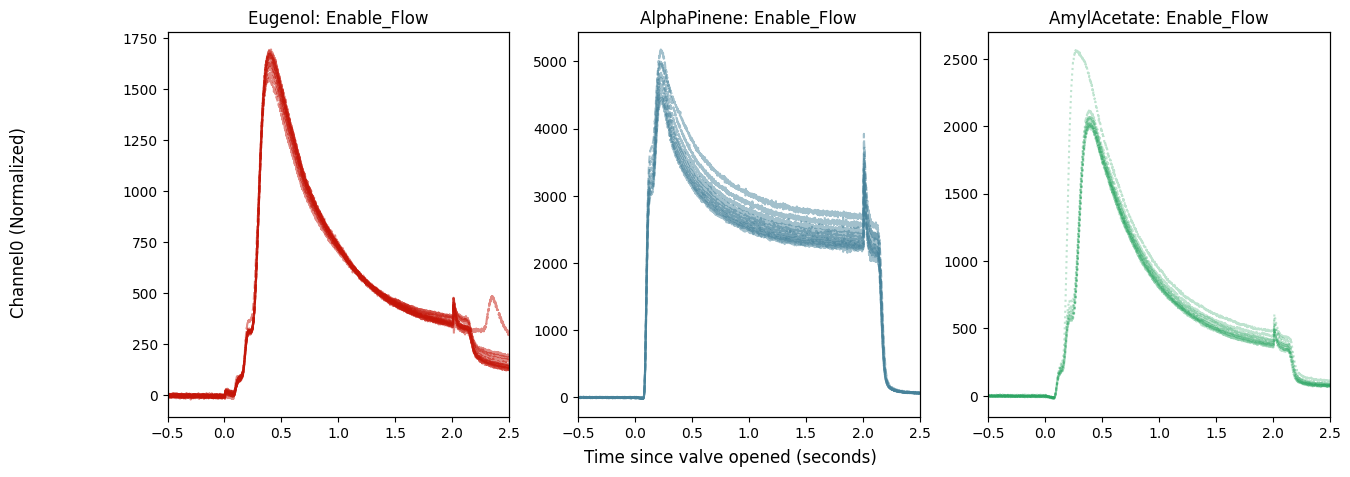

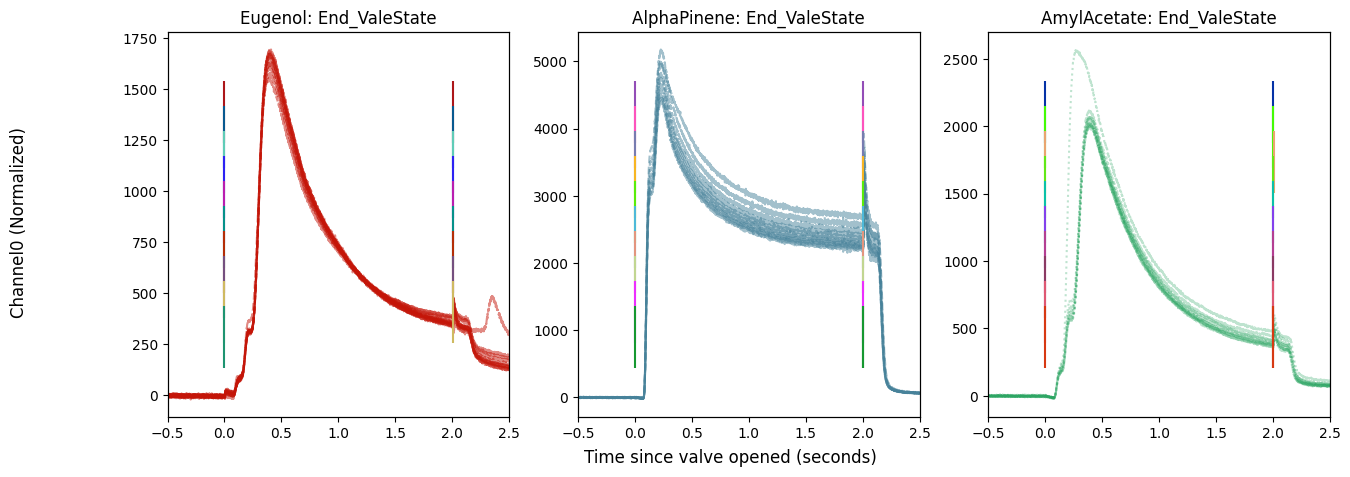

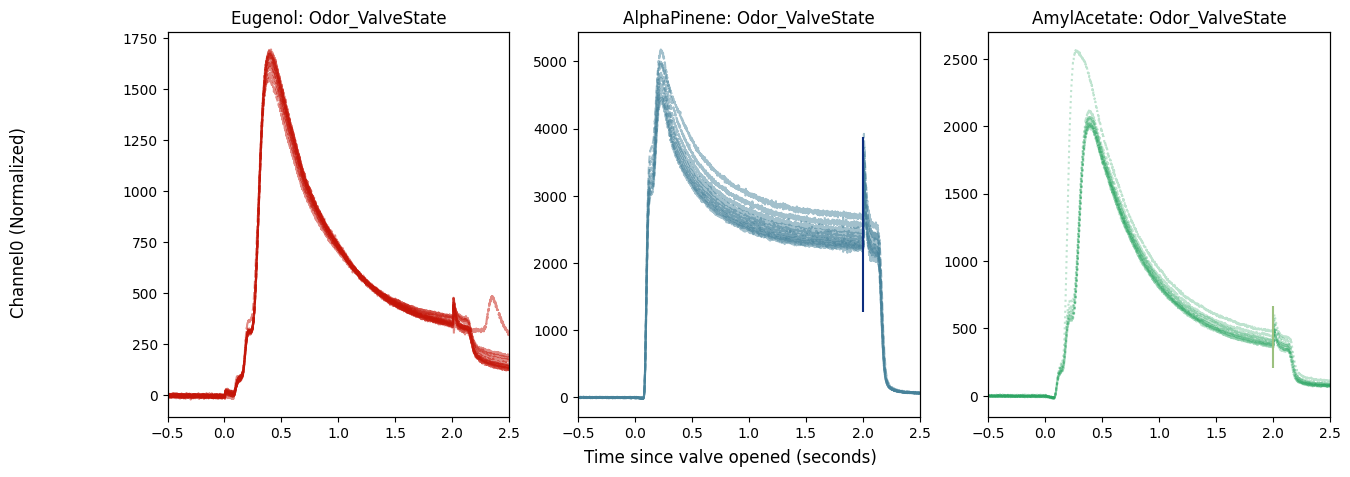

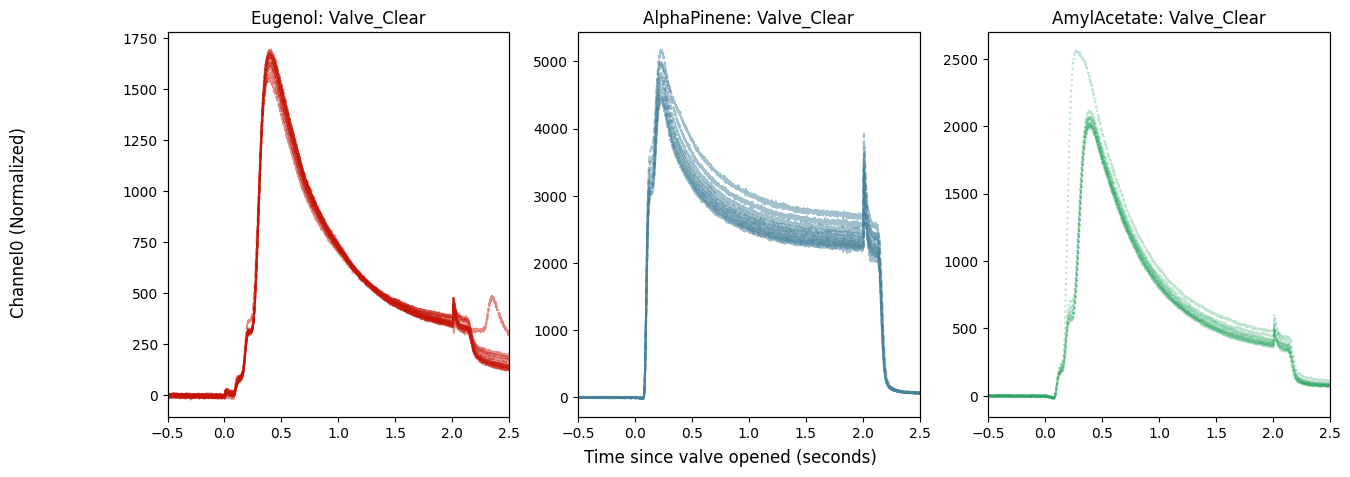

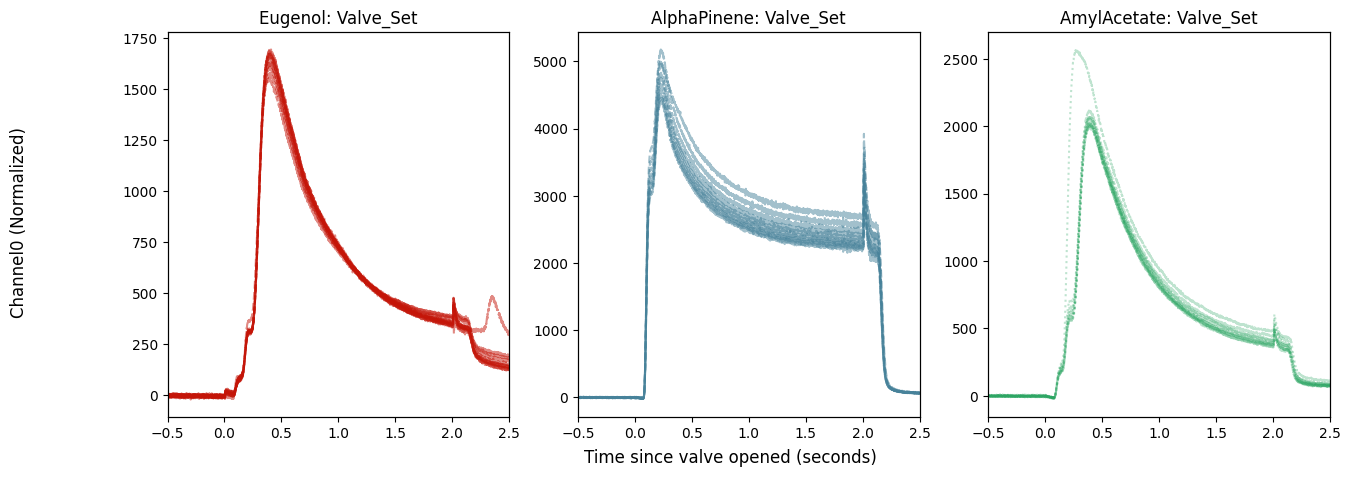

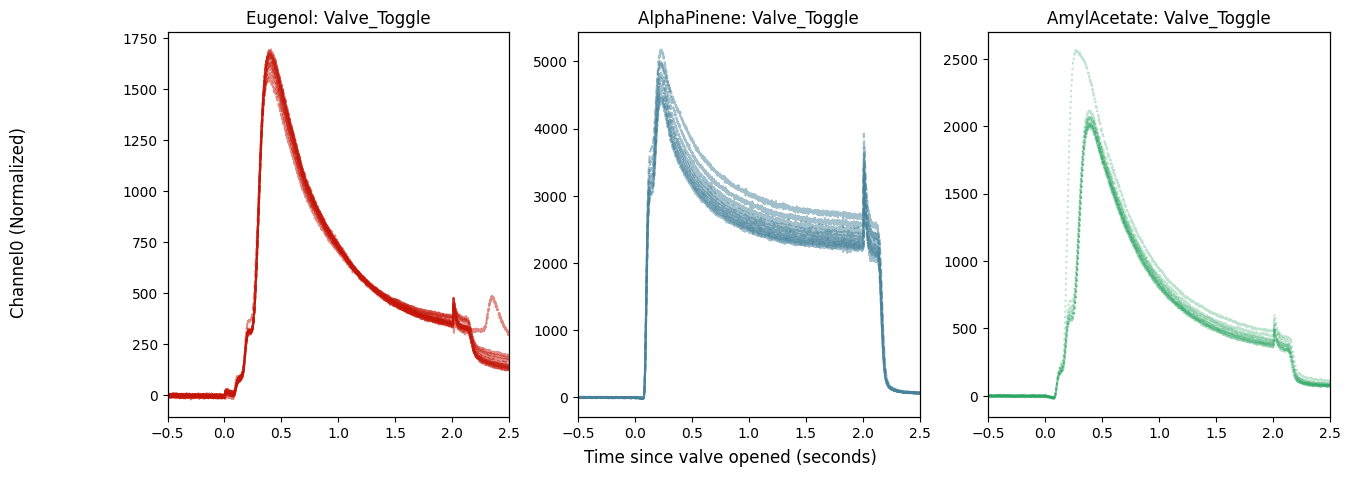

In [80]:
random.seed(123)
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
event_col = valve_status.iloc[:, 13:20].columns
offsets = 12

for event in range(len(event_col)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1_1 = ax1.twinx()
    ax2_1 = ax2.twinx()
    ax3_1 = ax3.twinx() 

    for i, v in valve_status[valve_status['channel_index'] == 0].iterrows():
        ax1.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508', alpha = .5, linestyle = '--')
        tmp_val = np.array(
            [z - v['time_valve_open'] for z in v[event_col[event]]]
        )
        ax1_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax1.set_title("Eugenol: " + event_col[event])
    ax1.set_xlim(-.5, 2.5)
    
    for i, v in valve_status[valve_status['channel_index'] == 1].iterrows():
        ax2.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#47829A', alpha = .5, linestyle = '--')
        tmp_val = np.array(
            [z - v['time_valve_open'] for z in v[event_col[event]]]
        )
        ax2_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax2.set_title("AlphaPinene: " + event_col[event])
    ax2.set_xlim(-.5, 2.5)
    
    for i, v in valve_status[valve_status['channel_index'] == 2].iterrows():
        ax3.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#28A460', alpha = .3, linestyle = 'dotted')
        tmp_val = np.array(
            [z - v['time_valve_open'] for z in v[event_col[event]]]
        )
        ax3_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax3.set_title("AmylAcetate: " + event_col[event])
    ax3.set_xlim(-.5, 2.5)
    
    ax1_1.set_yticks([])
    ax2_1.set_yticks([])
    ax3_1.set_yticks([])
    
    fig.supxlabel('Time since valve opened (seconds)')
    fig.supylabel('Channel0 (Normalized)')
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.show()

In [81]:
mix_status = pd.concat([mix_status, match_events(2)], axis = 1)

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_14800\118632093.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


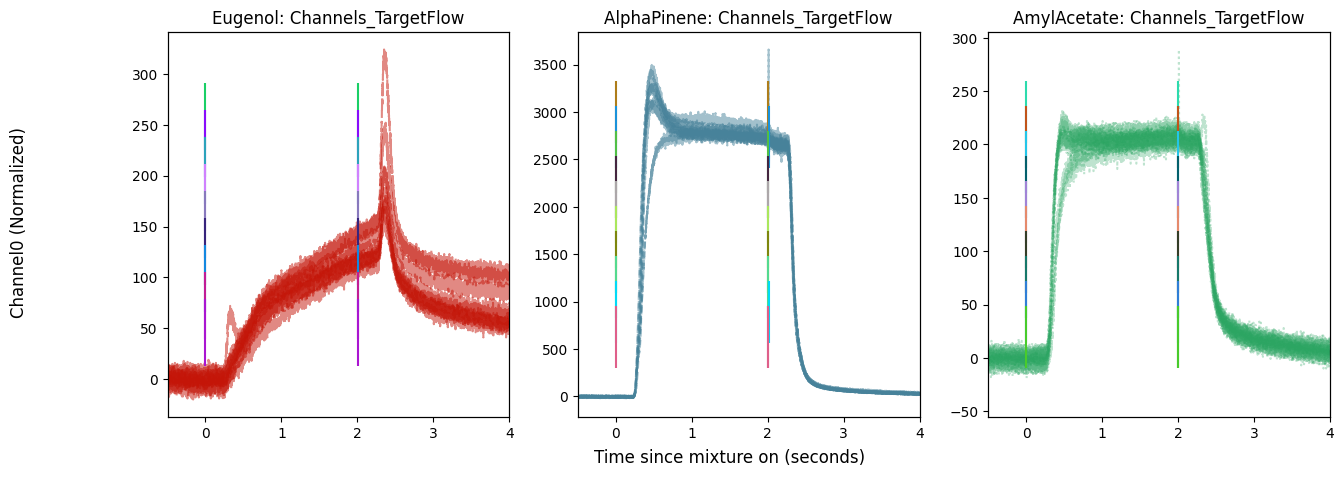

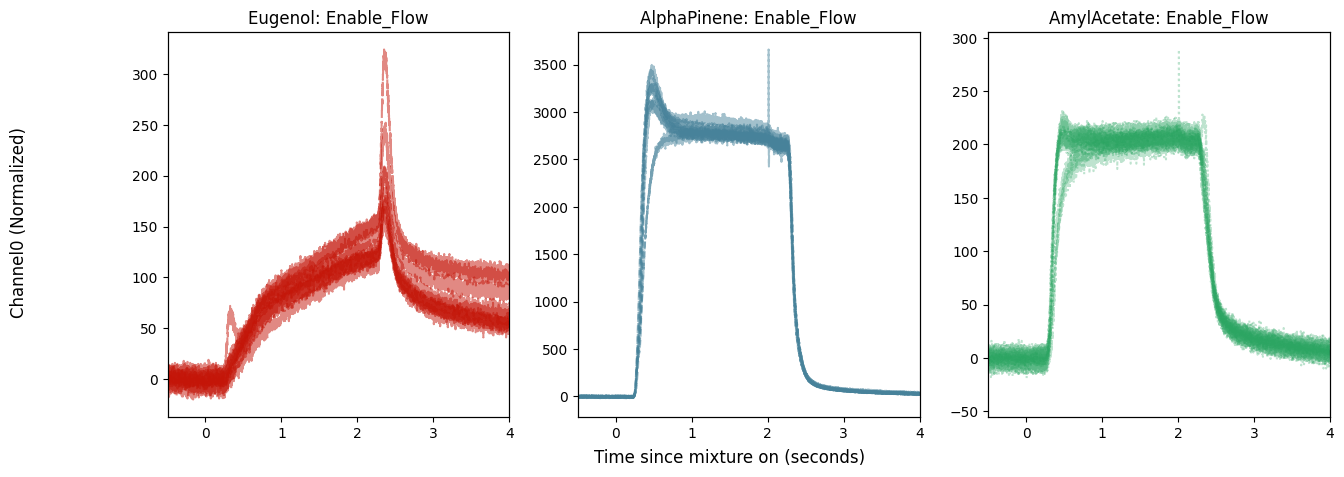

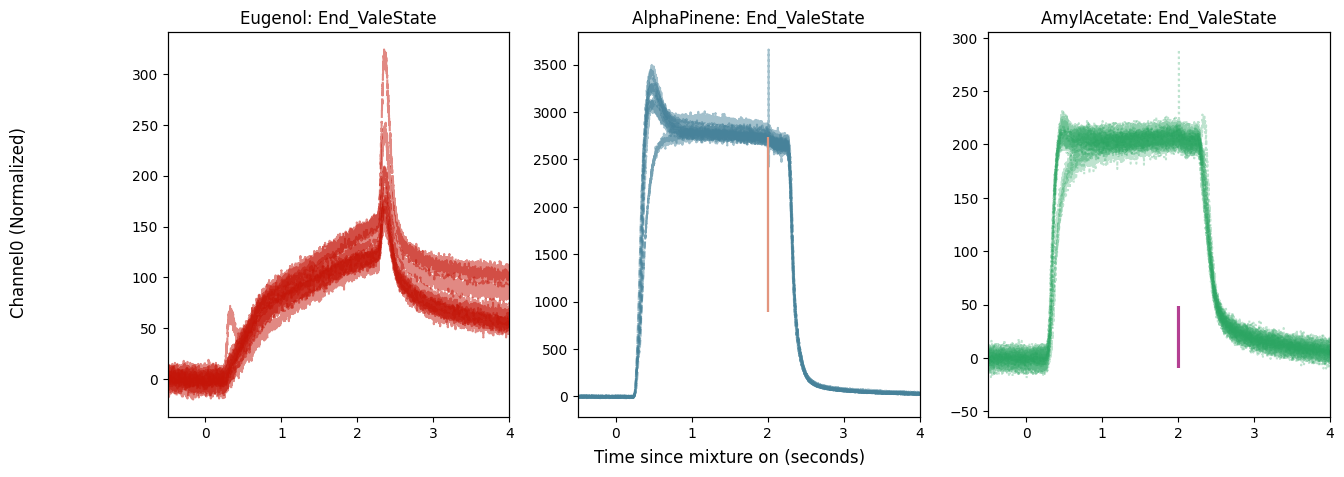

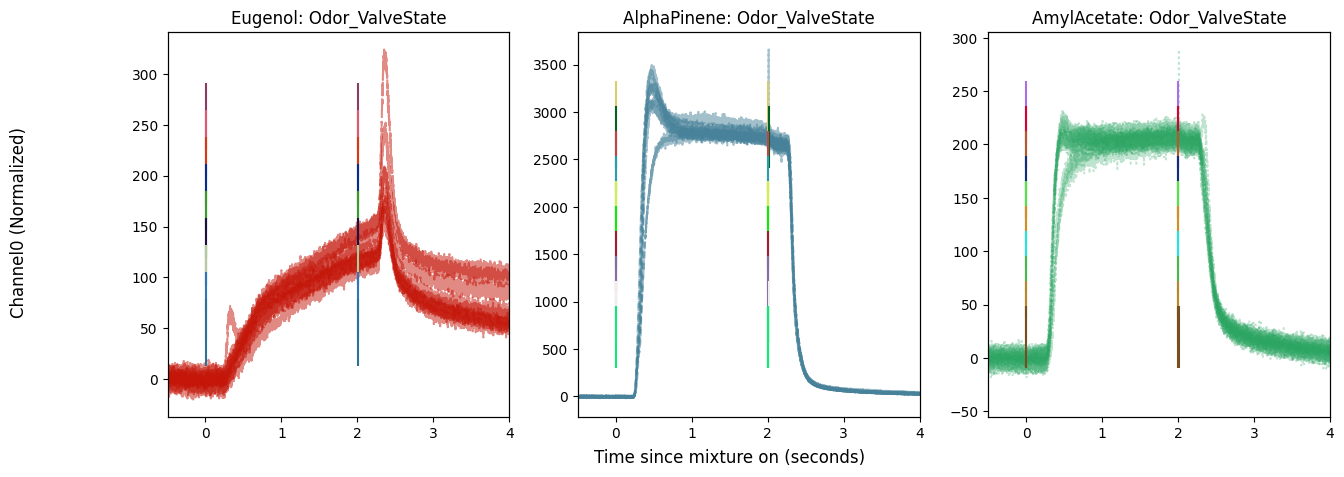

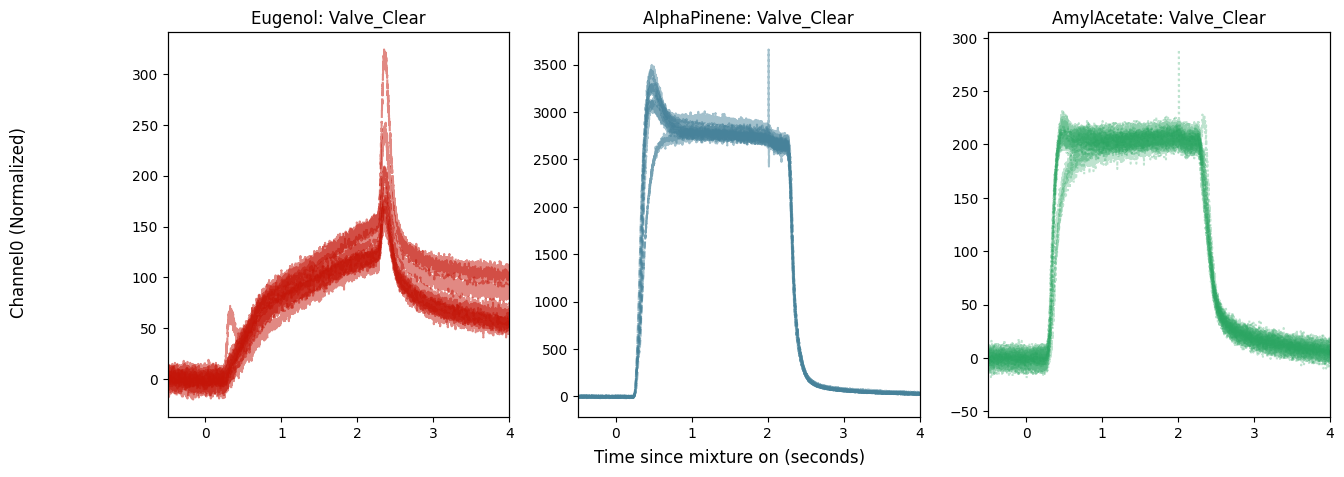

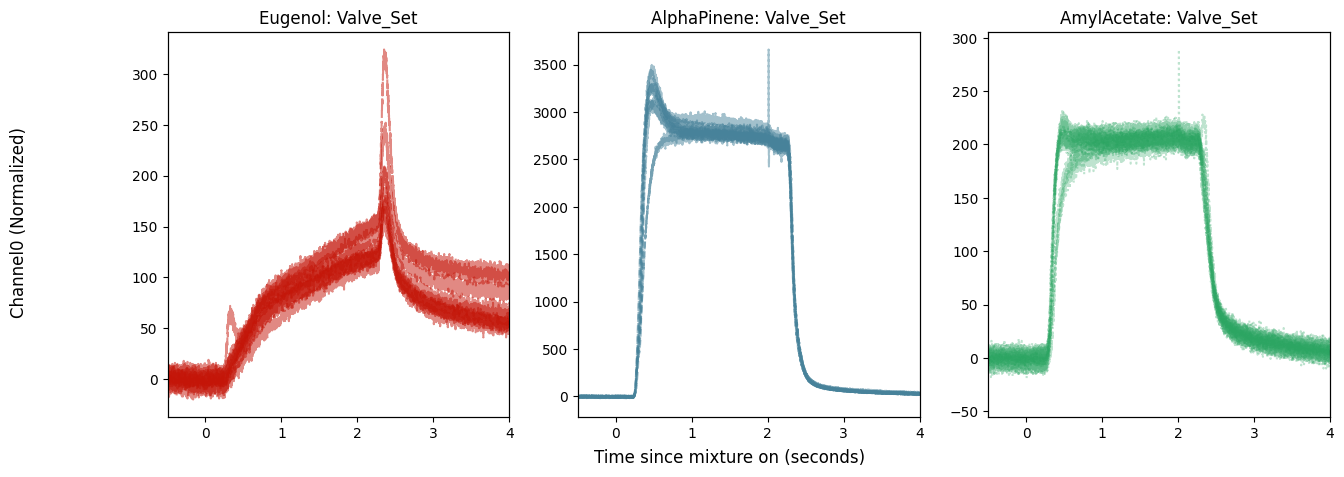

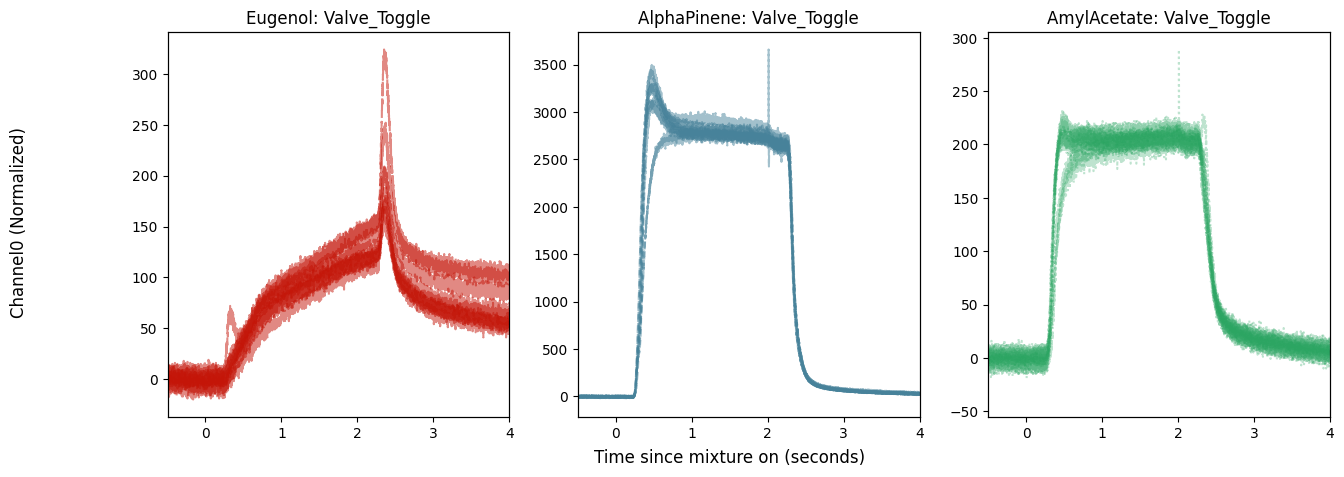

In [82]:
random.seed(123)
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
event_col = mix_status.iloc[:, 12:19].columns
offsets = 12

for event in range(len(event_col)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1_1 = ax1.twinx()
    ax2_1 = ax2.twinx()
    ax3_1 = ax3.twinx() 

    for i, v in mix_status[mix_status['channel_index'] == 0].iterrows():
        ax1.plot([x - v['time_mixture_on'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508', alpha = .5, linestyle = '--')
        tmp_val = np.array(
            [z - v['time_mixture_on'] for z in v[event_col[event]]]
        )
        ax1_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax1.set_title("Eugenol: " + event_col[event])
    ax1.set_xlim(-.5, 4)
    
    for i, v in mix_status[mix_status['channel_index'] == 1].iterrows():
        ax2.plot([x - v['time_mixture_on'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#47829A', alpha = .5, linestyle = '--')
        tmp_val = np.array(
            [z - v['time_mixture_on'] for z in v[event_col[event]]]
        )
        ax2_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax2.set_title("AlphaPinene: " + event_col[event])
    ax2.set_xlim(-.5, 4)
    
    for i, v in mix_status[mix_status['channel_index'] == 2].iterrows():
        ax3.plot([x - v['time_mixture_on'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#28A460', alpha = .3, linestyle = 'dotted')
        tmp_val = np.array(
            [z - v['time_mixture_on'] for z in v[event_col[event]]]
        )
        ax3_1.eventplot(tmp_val, lineoffsets=offsets, colors = get_colors(1), linelengths = 5)
        offsets -= 2

    ax3.set_title("AmylAcetate: " + event_col[event])
    ax3.set_xlim(-.5, 4)
    
    ax1_1.set_yticks([])
    ax2_1.set_yticks([])
    ax3_1.set_yticks([])
    
    fig.supxlabel('Time since mixture on (seconds)')
    fig.supylabel('Channel0 (Normalized)')
    fig.set_figheight(5)
    fig.set_figwidth(15)
    fig.show()